       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

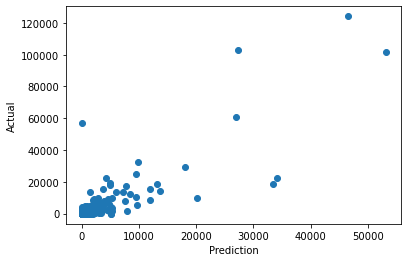

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data.csv', engine='python')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format = '%Y/%m/%d %H:%M:%S')
print(data)
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
data['Revenue'] = data['Quantity'] * data['UnitPrice']
print(data)
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')

    total_rev = features_data.groupby('CustomerID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('CustomerID')['date'].max() - features_data.groupby('CustomerID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('CustomerID')['InvoiceNo'].count().rename('frequency')
    t = features_data.groupby('CustomerID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('CustomerID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('CustomerID')['InvoiceNo'].count().rename('num_returns')
    hour = features_data.groupby('CustomerID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('CustomerID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('CustomerID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = data.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend], how ="inner")
    train_data = train_data.fillna(0)

    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['CustomerID'])['date'].nunique()
    target_rev = target_data.groupby(['CustomerID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)

    return train_data.iloc[:, :-1], train_data.iloc[:, -1] #X and Y


X_train, y_train = get_features(data, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')
X_test, y_test = get_features(data, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')
print(X_test)
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

    return model

early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=50)

model = build_model()
early_history = model.fit(X_train, y_train,
                    epochs=1000, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

def evaluate(actual, sales_prediction):
    print("\n")
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

dnn_preds = model.predict(X_test).ravel()

evaluate(y_test, dnn_preds)